In [2]:
!pip install tika pymorphy2

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import string
from tqdm.notebook import tqdm
import matplotlib
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pymorphy2

from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tika
from tika import parser
import re
import os
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /home/ami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ami/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ami/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ami/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
classes = pd.read_json('classes.json', orient='index')

In [5]:
classes.head(2)

,0
5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки
14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки


In [6]:
list_docs = os.listdir('docs')

In [7]:
tika.initVM()

for doc in tqdm(list_docs):
  parsed = parser.from_file('docs/' + doc)
  # classes.loc[doc, 'metadata'] = parsed["metadata"]
  classes.loc[doc, 'content'] = parsed["content"]

  0%|          | 0/120 [00:00<?, ?it/s]

In [8]:
%%time
stop_words = set(stopwords.words('russian')) # множество стоп слов

morph = pymorphy2.MorphAnalyzer() # для постановки слова в начальную форму

def lemmatize_words(text):
    '''Функция для лемматизации отдельных слов.'''
    final_text = []
    for i in text.lower().split():
        if i not in stop_words:
            parse = morph.parse(i)[0]
            if ('Abbr' not in parse.tag):
                final_text.append(parse.normal_form)               
    return " ".join(final_text)

def text_preprocessing(text):
    data = text.copy()

    # удаляем пунктуацию
    data['content_punct'] = data['content'].str.translate(str.maketrans('', '', string.punctuation))
    # Приводим к начальной форме
    data['content_punct_lemm'] = data['content_punct'].apply(lemmatize_words)
    
    return data

classes_prep = text_preprocessing(classes)

# test_copy = test.copy()
# test_copy.rename(columns={'text': 'sentence'}, inplace=True)
# test_prep = text_preprocessing(test_copy.fillna('нет текста'))

CPU times: user 10.8 s, sys: 20.3 ms, total: 10.9 s
Wall time: 10.9 s


In [9]:
le = LabelEncoder()
classes_prep['labels'] = le.fit_transform(classes_prep[0])

In [10]:
classes_prep[0].value_counts()

Договоры для акселератора/Договоры оказания услуг    32
Договоры для акселератора/Договоры аренды            23
Договоры для акселератора/Договоры купли-продажи     23
Договоры для акселератора/Договоры поставки          21
Договоры для акселератора/Договоры подряда           21
Name: 0, dtype: int64

In [11]:
def plot_LSA(test_data, test_labels):
    '''
    Функция для уменьшения размерности и визуализации векторного представления текстов по классам в проекции на плоскость
    '''
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['orange','blue','blue']
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='orange', label='0')
    green_patch = mpatches.Patch(color='blue', label='1')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 12})
    plt.title('Визуализация векторного представления текстов в проекции на плоскость', fontsize=14)

def plot_feature_importance(importance, names, model_name, numb_of_features=10):
    '''
    Для построения важности признаков
    '''
    # DataFrame из важности признаков модели с именами столбцов
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Сортируем по убыванию
    fi_df_sort = fi_df.sort_values(by=['feature_importance'], ascending=False)
    
    # Строим график
    if model_name == 'LogisticRegression':
        fig,ax = plt.subplots(2,1, figsize=(10,16))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features], ax=ax[0])
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[-numb_of_features:],ax=ax[1])
    else:
        fig,ax = plt.subplots(1,1, figsize=(10,8))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features])
        
    plt.title(model_name + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    

def learning(X_train, X_test, y_train, y_test, classifier, name_of_classifier, plot_lsa=False,
             ngram_range_user=(1,1), numb_of_features_user=10):
    '''
    Обучение модели. Возвращаем TfidfVectorizer для теста и обученный классификатор
    '''
    
    tf=TfidfVectorizer(ngram_range=ngram_range_user)
    X_train_tf = tf.fit_transform(X_train)
    X_test_tf = tf.transform(X_test)
    if plot_lsa == True:
        fig = plt.figure(figsize=(10, 8)) 
        plot_LSA(X_train_tf, y_train)
        plt.show()
    
    classifier.fit(X_train_tf, y_train)
    classifier_pred = classifier.predict(X_test_tf)
    classifier_pred_proba = classifier.predict_proba(X_test_tf)
    
    # print('{} confusion_matrix: \n'.format(name_of_classifier), confusion_matrix(y_test, classifier_pred))
    print('{} classification_report: \n'.format(name_of_classifier), classification_report(y_test, classifier_pred))
    # print('{} roc_auc: '.format(name_of_classifier), roc_auc_score(y_test, classifier_pred_proba, multi_class="ovr"))
    
    if name_of_classifier == 'LogisticRegression':
        plot_feature_importance(classifier.coef_[0],
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
    else:
        plot_feature_importance(classifier.feature_importances_,
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
        
    return tf, classifier

In [12]:
# Делим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(classes_prep['content_punct_lemm'],
                                                    classes_prep['labels'],
                                                    test_size=0.2, random_state=42,
                                                    stratify=classes_prep['labels'])

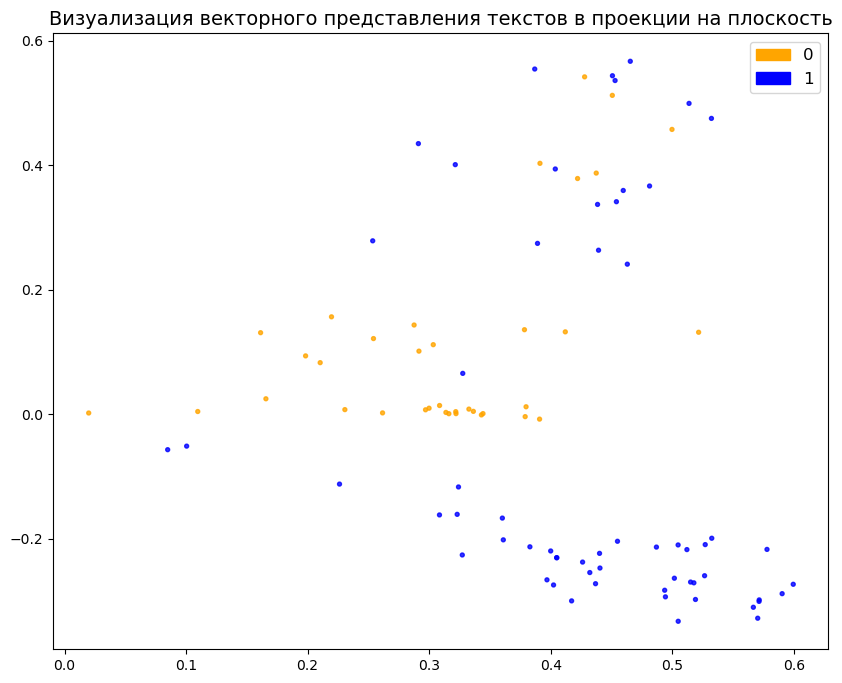

LogisticRegression classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.96        24
   macro avg       0.97      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



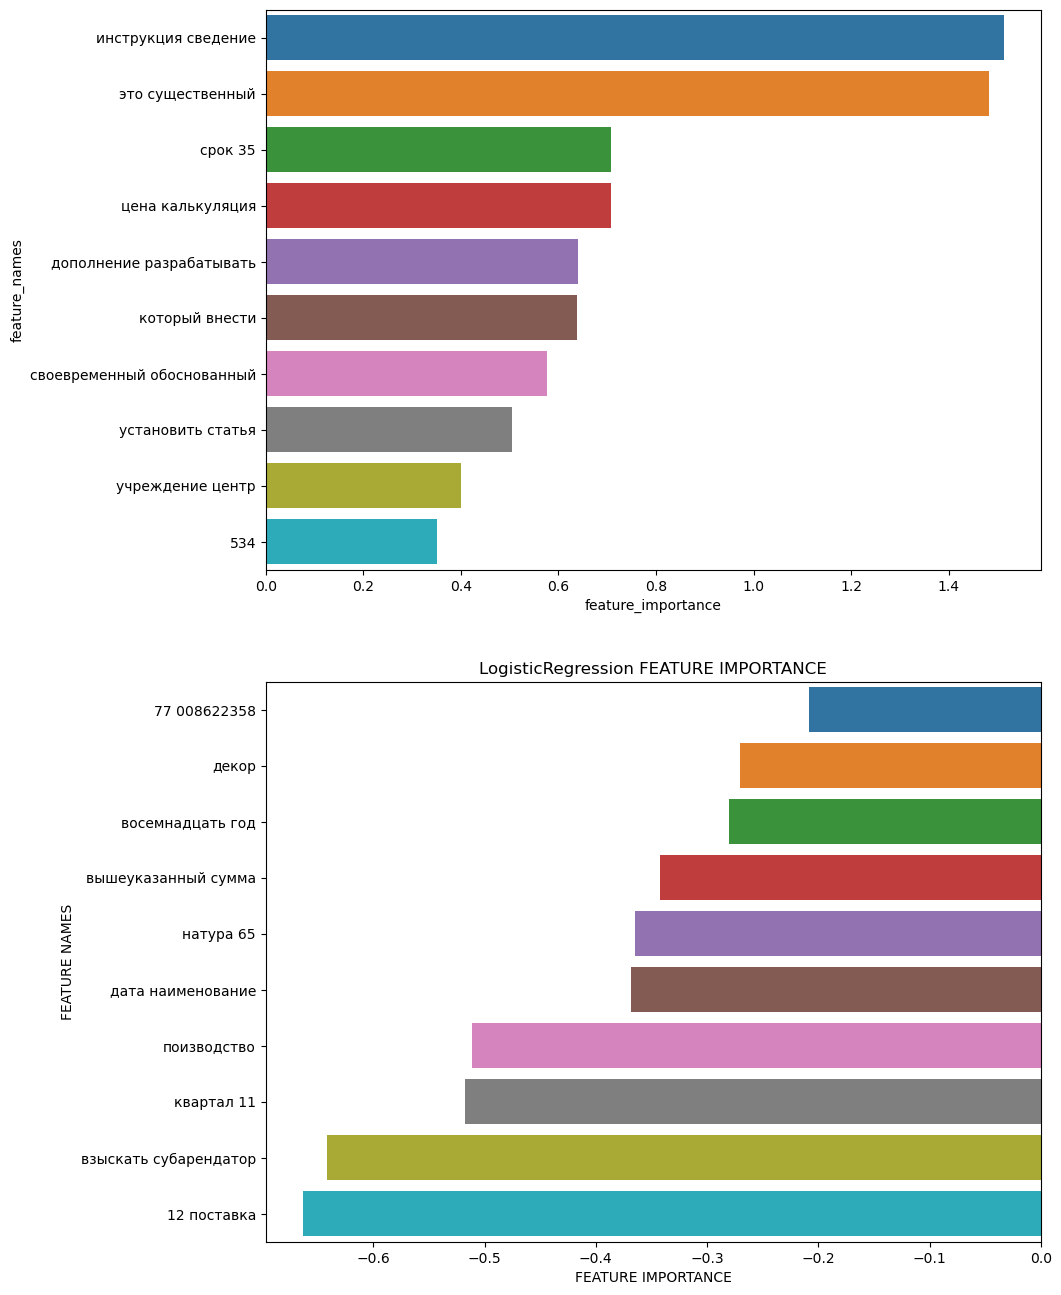

CPU times: user 976 ms, sys: 53.3 ms, total: 1.03 s
Wall time: 1.03 s


In [13]:
%%time
LR = LogisticRegression(random_state=42)
tf, LR_trained_classifier = learning(X_train, X_test, y_train, y_test, LR,
                                     'LogisticRegression', ngram_range_user=(1,2), plot_lsa=True)

In [15]:
import joblib

joblib.dump(tf, "tf.joblib")
joblib.dump(LR_trained_classifier, "LR_trained_classifier.joblib")

['LR_trained_classifier.joblib']

In [2]:
classes = pd.read_json('empty.json', orient='index')

In [3]:
classes

""


In [4]:
classes.add("dsfsdf")

""


In [5]:
classesclasses_prep

""


In [19]:
classes = pd.read_json('classes.json', orient='index')

In [20]:
classes[0].unique()

array(['Договоры для акселератора/Договоры поставки',
       'Договоры для акселератора/Договоры оказания услуг',
       'Договоры для акселератора/Договоры подряда',
       'Договоры для акселератора/Договоры аренды',
       'Договоры для акселератора/Договоры купли-продажи'], dtype=object)